In [85]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.linalg import svd

In [ ]:
mat_data = loadmat("../datasets/cuprite/CupriteS1_R188.mat") 
mat_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'SlectBands', 'nRow', 'nCol', 'nBand', 'Y'])

In [87]:
data = mat_data['Y'].astype(np.float64) 

In [88]:
rows = int(mat_data['nRow'][0][0])
cols = int(mat_data['nCol'][0][0])

if data.shape[0] < data.shape[1]:
    data = data.T  

pixels , bands = data.shape 
print(f"Data shape: {pixels, bands}")


Data shape: (47500, 188)


In [89]:
print(type(data))
print(getattr(data, "shape", "No shape attribute"))


<class 'numpy.ndarray'>
(47500, 188)


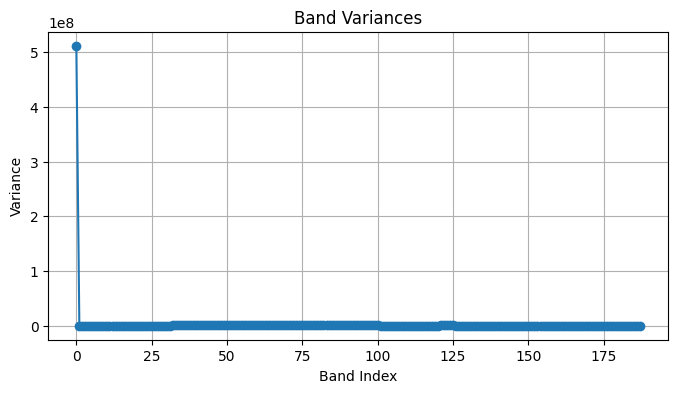

Min variance: 92018.42904205987
Max variance: 511722961.48055124
Mean variance: 3115299.5195146813


In [90]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate variance per band
band_variances = np.var(data, axis=0)

# Plot to see variance pattern
plt.figure(figsize=(8,4))
plt.plot(band_variances, marker='o')
plt.title("Band Variances")
plt.xlabel("Band Index")
plt.ylabel("Variance")
plt.grid(True)
plt.show()

# Print a few stats
print("Min variance:", band_variances.min())
print("Max variance:", band_variances.max())
print("Mean variance:", band_variances.mean())


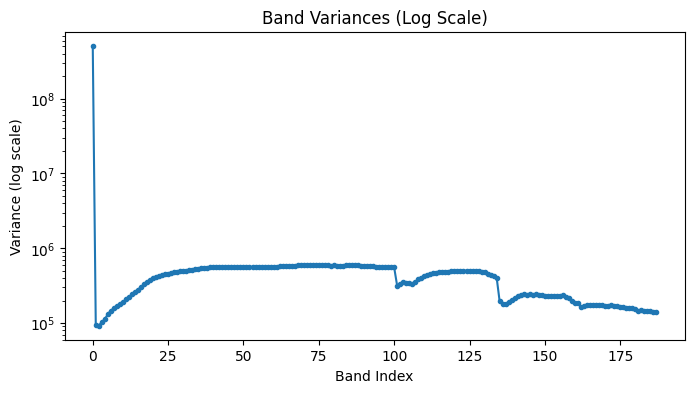

In [91]:
plt.figure(figsize=(8, 4))
plt.semilogy(band_variances, marker='.')
plt.title("Band Variances (Log Scale)")
plt.xlabel("Band Index")
plt.ylabel("Variance (log scale)")
plt.show()


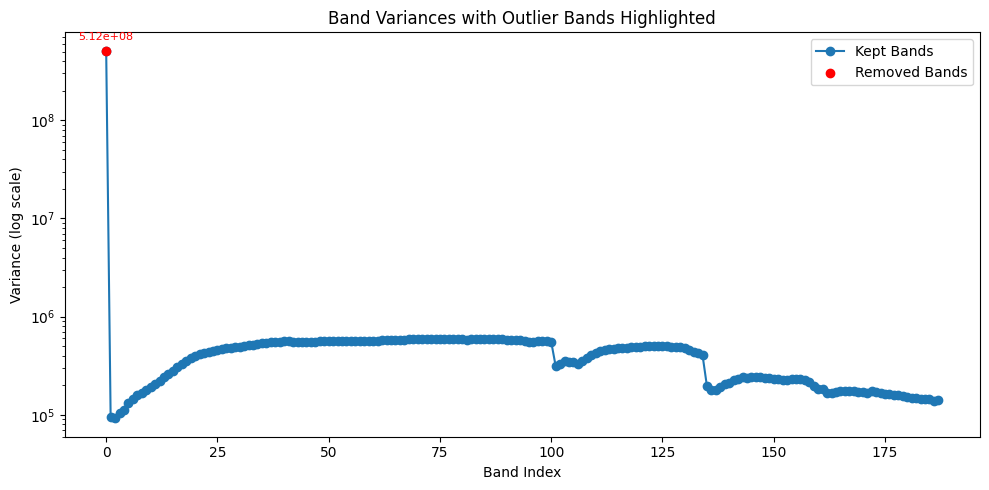

Original bands: 188
Kept bands: 187
Removed bands: 1
Removed band indices: [0]


In [92]:
import numpy as np
import matplotlib.pyplot as plt

def detect_good_bands(variances, z_thresh=3.0, save_plot=False, plot_filename="band_variances.png"):
    """
    Detect 'good' bands by removing statistical outliers in variance
    and plot the results.

    Args:
        variances: 1D numpy array of band variances.
        z_thresh: Z-score threshold for outlier detection (default=3).
        save_plot: If True, saves the plot to `plot_filename`.
        plot_filename: Name of file to save the plot.

    Returns:
        good_indices: indices of bands to keep
        bad_indices: indices of bands to remove
    """
    # Log transform to reduce skew
    log_var = np.log10(variances)

    # Z-score calculation
    z_scores = (log_var - np.mean(log_var)) / np.std(log_var)

    # Good and bad bands
    good_indices = np.where(np.abs(z_scores) <= z_thresh)[0]
    bad_indices = np.where(np.abs(z_scores) > z_thresh)[0]

    # --- Plotting ---
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(variances)), variances, marker='o', label="Kept Bands")
    plt.scatter(bad_indices, variances[bad_indices], color='red', label="Removed Bands", zorder=5)

    # Annotate removed bands
    for idx in bad_indices:
        plt.annotate(f"{variances[idx]:.2e}",
                     (idx, variances[idx]),
                     textcoords="offset points",
                     xytext=(0, 8),
                     ha='center',
                     fontsize=8,
                     color='red')

    plt.yscale("log")
    plt.xlabel("Band Index")
    plt.ylabel("Variance (log scale)")
    plt.title("Band Variances with Outlier Bands Highlighted")
    plt.legend()
    plt.tight_layout()

    if save_plot:
        plt.savefig(plot_filename, dpi=300)
    plt.show()

    return good_indices, bad_indices

# Example usage
good_bands, bad_bands = detect_good_bands(band_variances, z_thresh=3.0, save_plot=True)

print(f"Original bands: {len(band_variances)}")
print(f"Kept bands: {len(good_bands)}")
print(f"Removed bands: {len(bad_bands)}")
print("Removed band indices:", bad_bands)


removing noisy and water absorption bands 

In [ ]:
# Define the band indices to keep (excluding water absorption bands)
# Example: Assuming bands 100-110 and 150-160 are water absorption bands
bands_to_keep = [i for i in range(data.shape[1]) if i not in range(100, 111) and i not in (0,1) and i not in range(150, 161)]
cleaned_data = data[ :, bands_to_keep]

In [100]:
cleaned_data.shape[1]


164

In [101]:
scaler = MinMaxScaler()
nmf_ready_data = scaler.fit_transform(cleaned_data)

In [117]:
from sklearn.decomposition import NMF

# Number of endmembers/components to extract
n_components = 10  # change as needed

# Initialize NMF
nmf = NMF(n_components=n_components, init='nndsvda', random_state=42, max_iter=5000)

# Fit and transform
W = nmf.fit_transform(nmf_ready_data)  # abundance matrix
H = nmf.components_                    # endmember signatures

print("W (abundances) shape:", W.shape)
print("H (signatures) shape:", H.shape)


W (abundances) shape: (47500, 10)
H (signatures) shape: (10, 164)


In [118]:
abundances = W
endmembers = H

In [119]:
abundance_maps = abundances.reshape(rows, cols, n_components)

In [120]:
print("Endmembers shape:", endmembers.shape)
print("Abundance maps shape:", abundance_maps.shape)

Endmembers shape: (10, 164)
Abundance maps shape: (250, 190, 10)


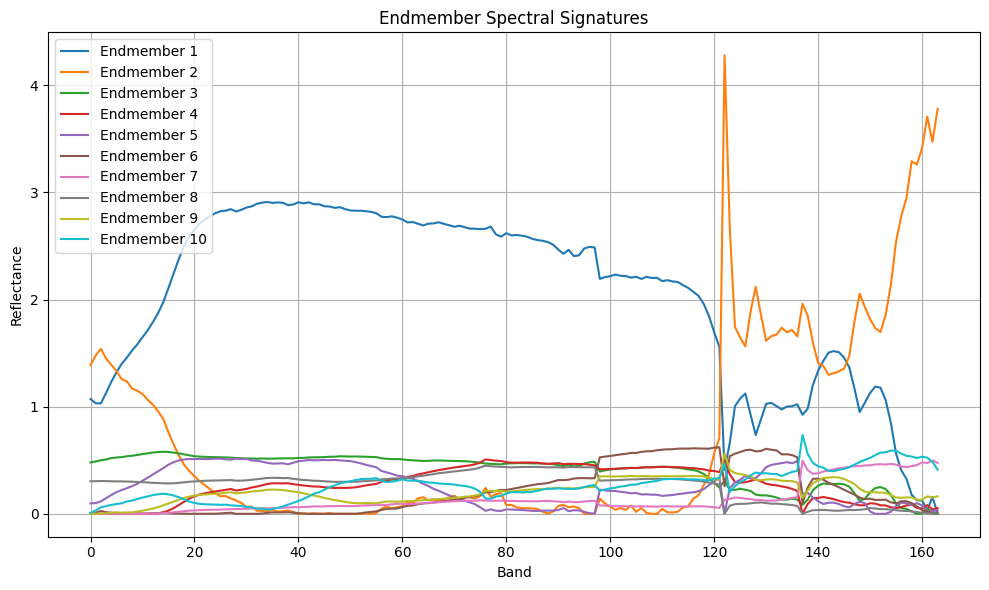

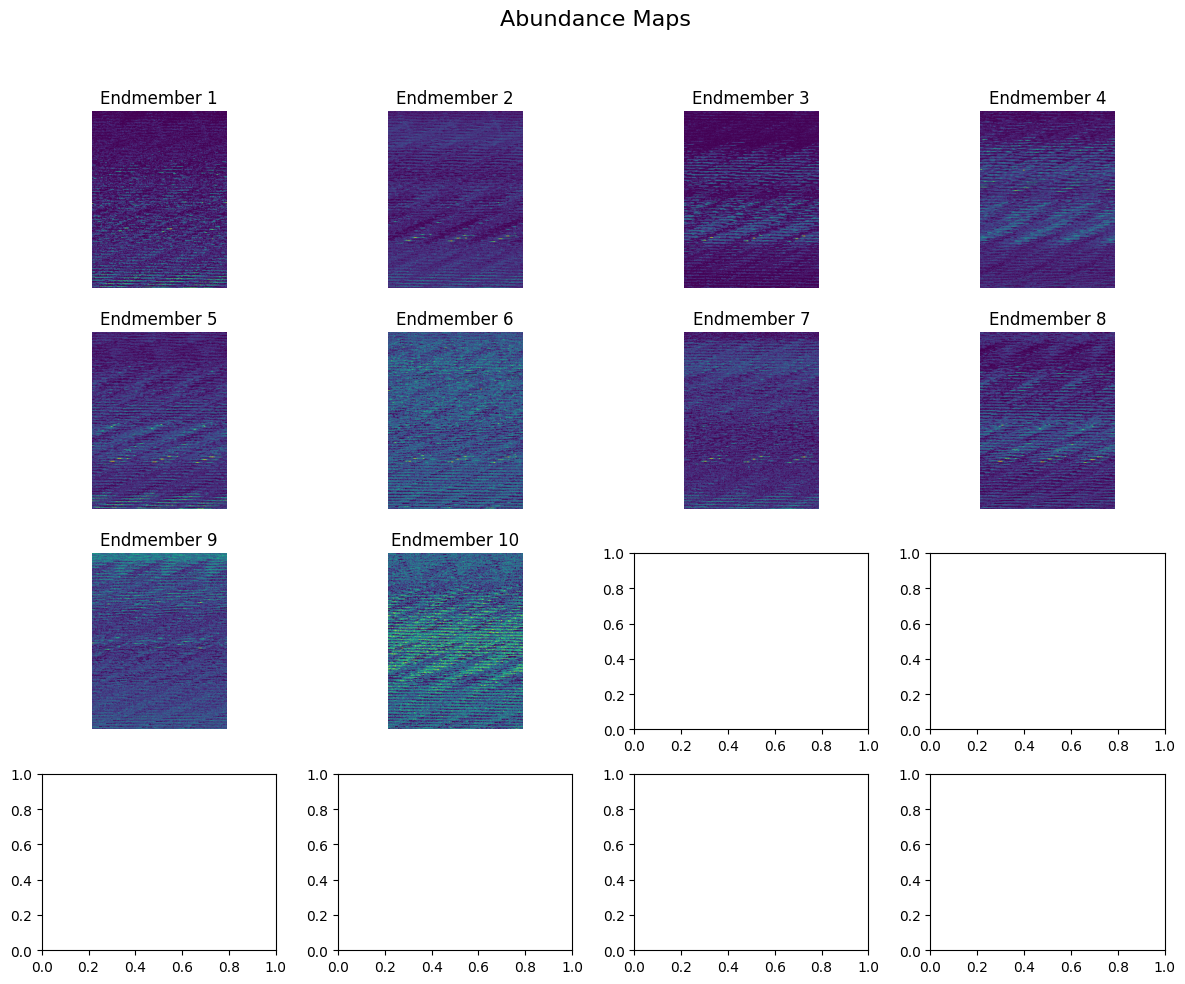

In [121]:
# ---- 1. Plot Endmember Spectral Signatures ----
plt.figure(figsize=(10, 6))
for i in range(endmembers.shape[0]):
    plt.plot(range(endmembers.shape[1]), endmembers[i], label=f'Endmember {i+1}')
plt.xlabel('Band')
plt.ylabel('Reflectance')
plt.title('Endmember Spectral Signatures')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- 2. Plot Abundance Maps ----
fig, axes = plt.subplots(4, 4, figsize=(12, 10))
fig.suptitle('Abundance Maps', fontsize=16)
for i in range(abundance_maps.shape[2]):
    ax = axes[i // 4, i % 4]
    ax.imshow(abundance_maps[:, :, i], cmap='viridis')
    ax.set_title(f'Endmember {i+1}')
    ax.axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
